# Single-Cell RNA Sequencing Analysis of Tabula Muris Senis: Aorta Data

## Introduction
The Tabula Muris Senis dataset provides single-cell RNA sequencing (scRNA-seq) data across multiple mouse tissues, including the aorta. This project focuses on analyzing the FACS dataset for the aorta using **Scanpy**, a Python-based library for scRNA-seq data analysis.

### Objectives
1. Preprocess and normalize single-cell RNA sequencing data.
2. Identify and visualize distinct cell populations in the aorta.
3. Perform differential expression analysis to discover cell-type-specific marker genes.

This analysis offers insights into the cellular composition and gene expression profiles of the mouse aorta, contributing to our understanding of vascular biology and related systems.

In [25]:
import scanpy as sc
import anndata
import matplotlib 
import seaborn as sns
from sklearn.metrics import silhouette_score
import numpy as np

In [26]:
# Load the aorta dataset
adata = sc.read_h5ad('/Users/kryptonempyrean/Desktop/tabula-muris-senis-facs-processed-official-annotations-Aorta.h5ad')

# Quick overview of the dataset
print(adata)

AnnData object with n_obs × n_vars = 906 × 22966
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'louvain', 'leiden'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'cell_ontology_class_colors', 'leiden', 'louvain', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


/Users/kryptonempyrean/Library/Python/3.9/lib/python/site-packages/anndata/compat/__init__.py:329: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/kryptonempyrean/Library/Python/3.9/lib/python/site-packages/anndata/compat/__init__.py:329: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


### Preprocessing Steps

1. **Filter Cells and Genes**:
   - Remove cells with fewer than 200 expressed genes to ensure sufficient gene coverage:
     ```python
     sc.pp.filter_cells(adata, min_genes=200)
     ```
   - Remove genes expressed in fewer than 3 cells to exclude uninformative genes:
     ```python
     sc.pp.filter_genes(adata, min_cells=3)
     ```

2. **Normalize Total Counts**:
   - Scale the total counts for each cell to 10,000 to account for differences in sequencing depth:
     ```python
     sc.pp.normalize_total(adata, target_sum=1e4)
     ```

3. **Log Transformation**:
   - Apply a log(x + 1) transformation to normalize the distribution of gene expression:
     ```python
     sc.pp.log1p(adata)
     ```

4. **Select Highly Variable Genes**:
   - Identify the top 2,000 most variable genes, which are most likely to contribute to cell population differences:
     ```python
     sc.pp.highly_variable_genes(adata, n_top_genes=2000)
     adata = adata[:, adata.var.highly_variable]
     ```

5. **Scale the Data**:
   - Standardize each gene to have zero mean and unit variance, capping extreme values at 10 to reduce the influence of outliers:
     ```python
     sc.pp.scale(adata, max_value=10)
     ```

This preprocessing pipeline ensures the data is clean, normalized, and optimized for clustering and dimensionality reduction.


In [27]:
# Preprocessing
sc.pp.filter_cells(adata, min_genes=200)  
sc.pp.filter_genes(adata, min_cells=3)   
sc.pp.normalize_total(adata, target_sum=1e4)  
sc.pp.log1p(adata) 

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]  # Subset to highly variable genes

# Scale the data
sc.pp.scale(adata, max_value=10)

/Users/kryptonempyrean/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Principal Component Analysis (PCA)

1. **Perform PCA**:
   - PCA reduces the dimensionality of the dataset by identifying the directions (principal components) that capture the most variance:
     ```python
     sc.tl.pca(adata, svd_solver='arpack')
     ```

2. **Variance Explained by Each Principal Component**:
   - Visualize the proportion of variance explained by each principal component (PC) using a logarithmic scale:
     ```python
     sc.pl.pca_variance_ratio(adata, log=True)
     ```

### Key Points:
- The plot shows the contribution of each PC to the total variance in the dataset.
- The **elbow point** in the plot indicates the number of PCs that capture most of the meaningful variance. PCs beyond this point usually represent noise.
- The first few PCs (e.g., 10–20) typically explain a significant portion of the variance and are used for downstream analyses like clustering and UMAP.

This step helps identify the optimal number of PCs to retain for further analysis while reducing noise and computational complexity.


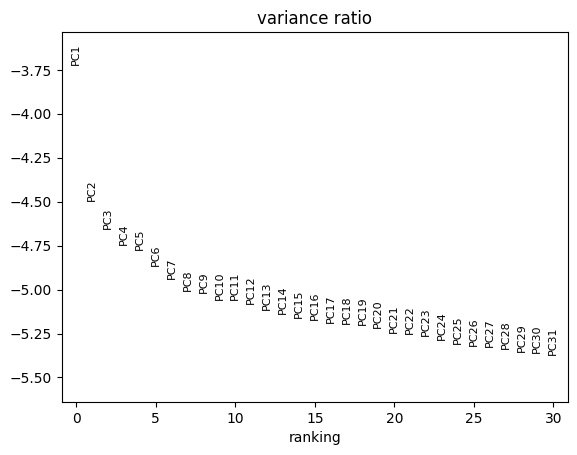

In [28]:
# Principal Component Analysis
sc.tl.pca(adata, svd_solver='arpack')

# Visualize the variance explained by each PC
sc.pl.pca_variance_ratio(adata, log=True)

The plot above shows the proportion of variance explained by each principal component (PC) in a logarithmic scale.

1. **X-Axis (Ranking)**:
   - The ranking of the principal components (PC1, PC2, PC3, etc.), ordered by the amount of variance they explain.
   - PC1 explains the most variance, followed by PC2, and so on.

2. **Y-Axis (Logarithmic Variance Ratio)**:
   - The variance explained by each principal component, displayed on a logarithmic scale for better visualization of differences across PCs.

3. **Key Observations**:
   - The first few principal components (e.g., PC1 to PC6) explain the majority of the variance.
   - Beyond PC6, the variance explained by each PC decreases steadily, with no major contribution from higher PCs.
   - The **elbow point** appears around PC6–PC8, indicating that these components capture most of the meaningful variance, and subsequent PCs likely represent noise.

4. **Implications**:
   - Retain the first 6–8 PCs for downstream analyses such as clustering and dimensionality reduction (e.g., UMAP).
   - This ensures the meaningful patterns in the data are preserved while reducing computational complexity.

This plot is critical for determining the optimal number of PCs to include in further analyses while minimizing the inclusion of noise.







### Neighborhood Graph, UMAP Embedding, and Clustering

1. **Compute the Neighborhood Graph**:
   - `sc.pp.neighbors(adata, n_neighbors=10, n_pcs=8)`:
     - Builds a k-nearest neighbors (kNN) graph based on the first 8 principal components (PCs).
     - `n_neighbors=10` specifies the number of neighbors considered for each cell, influencing the granularity of clustering.
     - The graph represents the local relationships between cells and is used as input for clustering and dimensionality reduction.

2. **UMAP Embedding**:
   - `sc.tl.umap(adata)`:
     - Uniform Manifold Approximation and Projection (UMAP) reduces the dataset's dimensionality to 2D or 3D while preserving the local and global structure.
     - This step creates a visual representation of the data, making it easier to identify clusters.

3. **Clustering with Leiden Algorithm**:
   - `sc.tl.leiden(adata)`:
     - Applies the Leiden algorithm on the neighborhood graph to identify clusters of similar cells.
     - Each cluster groups cells with similar gene expression profiles, representing distinct cell populations or states.

4. **Visualize Clusters with UMAP**:
   - `sc.pl.umap(adata, color=['leiden', 'cell_ontology_class'])`:
     - Creates a UMAP plot where each point represents a cell, colored by:
       - `leiden`: Clusters identified by the Leiden algorithm.
       - `cell_ontology_class`: Known cell-type annotations, if available, for comparison.

### Key Insights:
- The UMAP plot shows the spatial arrangement of cells based on their gene expression profiles.
- Distinct clusters indicate heterogeneous cell populations, which can be compared to known cell types for annotation.
- The resolution of clustering depends on parameters like `n_neighbors` and the number of PCs used.

This step is crucial for exploring the dataset’s structure, identifying cell populations, and relating them to biological processes.


In [32]:
# Define a function to test different n_neighbors and calculate silhouette scores
def test_neighbors_and_silhouette(adata, n_neighbors_list, n_pcs):
    silhouette_scores = []

    for n_neighbors in n_neighbors_list:
        # Compute the neighborhood graph
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)
        
        # Perform clustering with Leiden algorithm
        sc.tl.leiden(adata, key_added=f'leiden_{n_neighbors}')
        
        # Compute the UMAP embedding
        sc.tl.umap(adata)
        
        # Get the cluster labels
        cluster_labels = adata.obs[f'leiden_{n_neighbors}']
        
        # Calculate the silhouette score (using PCA-reduced data)
        score = silhouette_score(adata.obsm['X_pca'], cluster_labels.astype('int'))
        silhouette_scores.append((n_neighbors, score))
        print(f"n_neighbors = {n_neighbors}, Silhouette Score = {score:.4f}")
    
    return silhouette_scores

# Parameters to test
n_neighbors_list = [5, 10, 15, 20, 30]  # List of neighborhood sizes to test
n_pcs = 15  # Number of PCs to use based on PCA analysis

# Run the test function
silhouette_results = test_neighbors_and_silhouette(adata, n_neighbors_list, n_pcs)

# Print results
print("\nSilhouette Scores for Different n_neighbors:")
for n_neighbors, score in silhouette_results:
    print(f"n_neighbors: {n_neighbors}, Silhouette Score: {score:.4f}")

n_neighbors = 5, Silhouette Score = -0.0696
n_neighbors = 10, Silhouette Score = -0.0800
n_neighbors = 15, Silhouette Score = -0.0413
n_neighbors = 20, Silhouette Score = -0.0418
n_neighbors = 30, Silhouette Score = -0.0572

Silhouette Scores for Different n_neighbors:
n_neighbors: 5, Silhouette Score: -0.0696
n_neighbors: 10, Silhouette Score: -0.0800
n_neighbors: 15, Silhouette Score: -0.0413
n_neighbors: 20, Silhouette Score: -0.0418
n_neighbors: 30, Silhouette Score: -0.0572


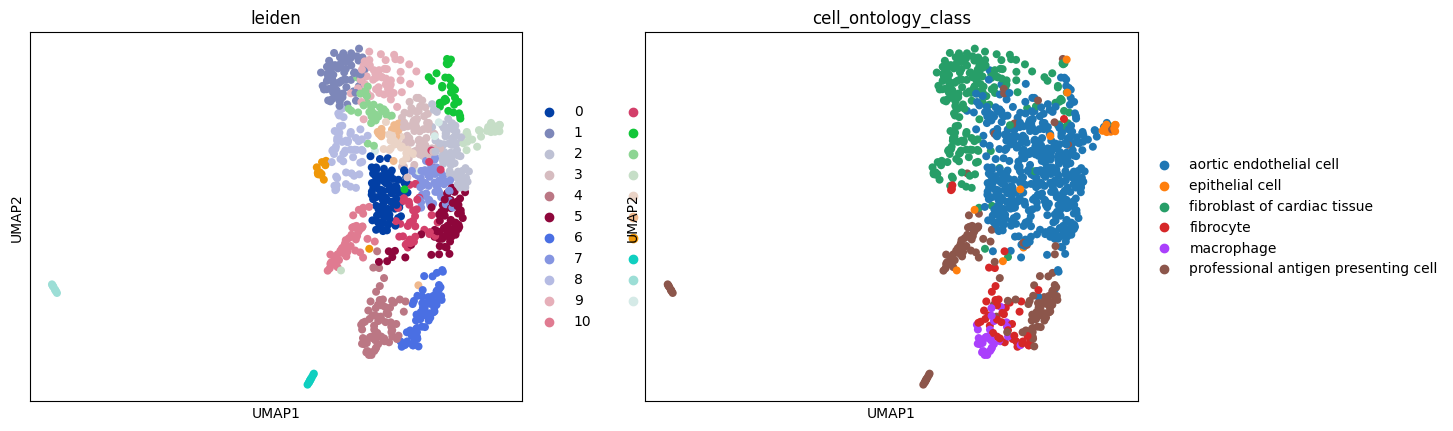

In [38]:
# Compute the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=15)

# UMAP embedding
sc.tl.umap(adata)

# Clustering with the Leiden algorithm
sc.tl.leiden(adata, resolution=2)

# Visualize UMAP with clusters
sc.pl.umap(adata, color=['leiden', 'cell_ontology_class'])

### UMAP Results with 15 PCs, 15 Neighbors, and Resolution of 2

1. **Left Plot: Leiden Clustering**
   - Each point represents a single cell, and its position is determined by the UMAP algorithm, which reduces the high-dimensional data to two dimensions (UMAP1 and UMAP2).
   - Colors indicate clusters identified by the Leiden algorithm.
   - A resolution of **2** creates a higher number of clusters, which can reveal finer subpopulations.
   - Some clusters are spatially distinct, indicating well-separated cell populations, while others overlap slightly, suggesting biological or technical similarities.

2. **Right Plot: Cell Ontology Class**
   - Points are colored by known cell type annotations (`cell_ontology_class`), revealing the biological identity of cells within the clusters.
   - Key cell types identified:
     - **Aortic endothelial cells** (blue): Likely vascular endothelial cells lining the aorta.
     - **Epithelial cells** (orange): Cells forming tissue linings or barriers.
     - **Fibroblasts of cardiac tissue** (green): Cells contributing to structural support in cardiac tissues.
     - **Fibrocytes** (red): Cells involved in tissue repair and maintenance.
     - **Macrophages** (purple): Immune cells involved in phagocytosis.
     - **Professional antigen-presenting cells** (brown): Immune cells involved in activating T cells.
   - The spatial arrangement of annotated cell types corresponds closely with the Leiden clusters, validating the clustering.

3. **Key Observations**:
   - Some clusters correspond to well-defined cell types (e.g., endothelial cells and fibroblasts).
   - Overlaps between clusters in the UMAP space suggest shared or transitional cell states (e.g., between fibroblasts and fibrocytes).
   - Smaller clusters may represent rare cell types or less abundant populations.

4. **Biological Interpretation**:
   - The dataset includes distinct vascular (e.g., endothelial) and immune (e.g., macrophage) populations, reflecting the expected composition of the aorta.
   - Rare populations (e.g., antigen-presenting cells) are well-separated, supporting the high resolution used.

5. **Next Steps**:
   - Perform **marker gene analysis** for each cluster to confirm and refine annotations.
   - Investigate overlapping regions to explore potential transitional or mixed cell states.
   - Use pathway enrichment analysis to understand the roles of each cell type in aortic biology.

This UMAP visualization demonstrates a clear structure within the dataset, with distinct clusters that align with known biological annotations.


### Identifying Marker Genes for Each Cluster

1. **Rank Marker Genes by Differential Expression**:
   - The `rank_genes_groups` function identifies marker genes for each cluster using a statistical test. In this case, a **t-test** is used to compare the expression levels of genes in each cluster against all other clusters:
     ```python
     sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
     ```

2. **Visualize Top Marker Genes**:
   - The `rank_genes_groups` plot shows the top differentially expressed genes for each cluster, ranked by their statistical significance. It provides an overview of the most distinct genes for each cell population:
     ```python
     sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)
     ```

### Key Observations:
- **Top Genes per Cluster**:
  - Each cluster is characterized by a unique set of marker genes, which can be used to identify the biological identity of the cluster.
  - For example, a cluster with high expression of **Pecam1** and **Vwf** likely represents endothelial cells.

- **Use of Marker Genes**:
  - The top marker genes can be used to:
    - Annotate cell types in each cluster by comparing with known gene markers.
    - Explore functional roles of each cell population in the aorta.
    - Investigate biological processes or pathways enriched in specific cell populations.

/Users/kryptonempyrean/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/Users/kryptonempyrean/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:459: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/Users/kryptonempyrean/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/Users/kryptonempyrean/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/kryptonempyrean/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: overflow encountered in expm1
  foldchanges = (sel

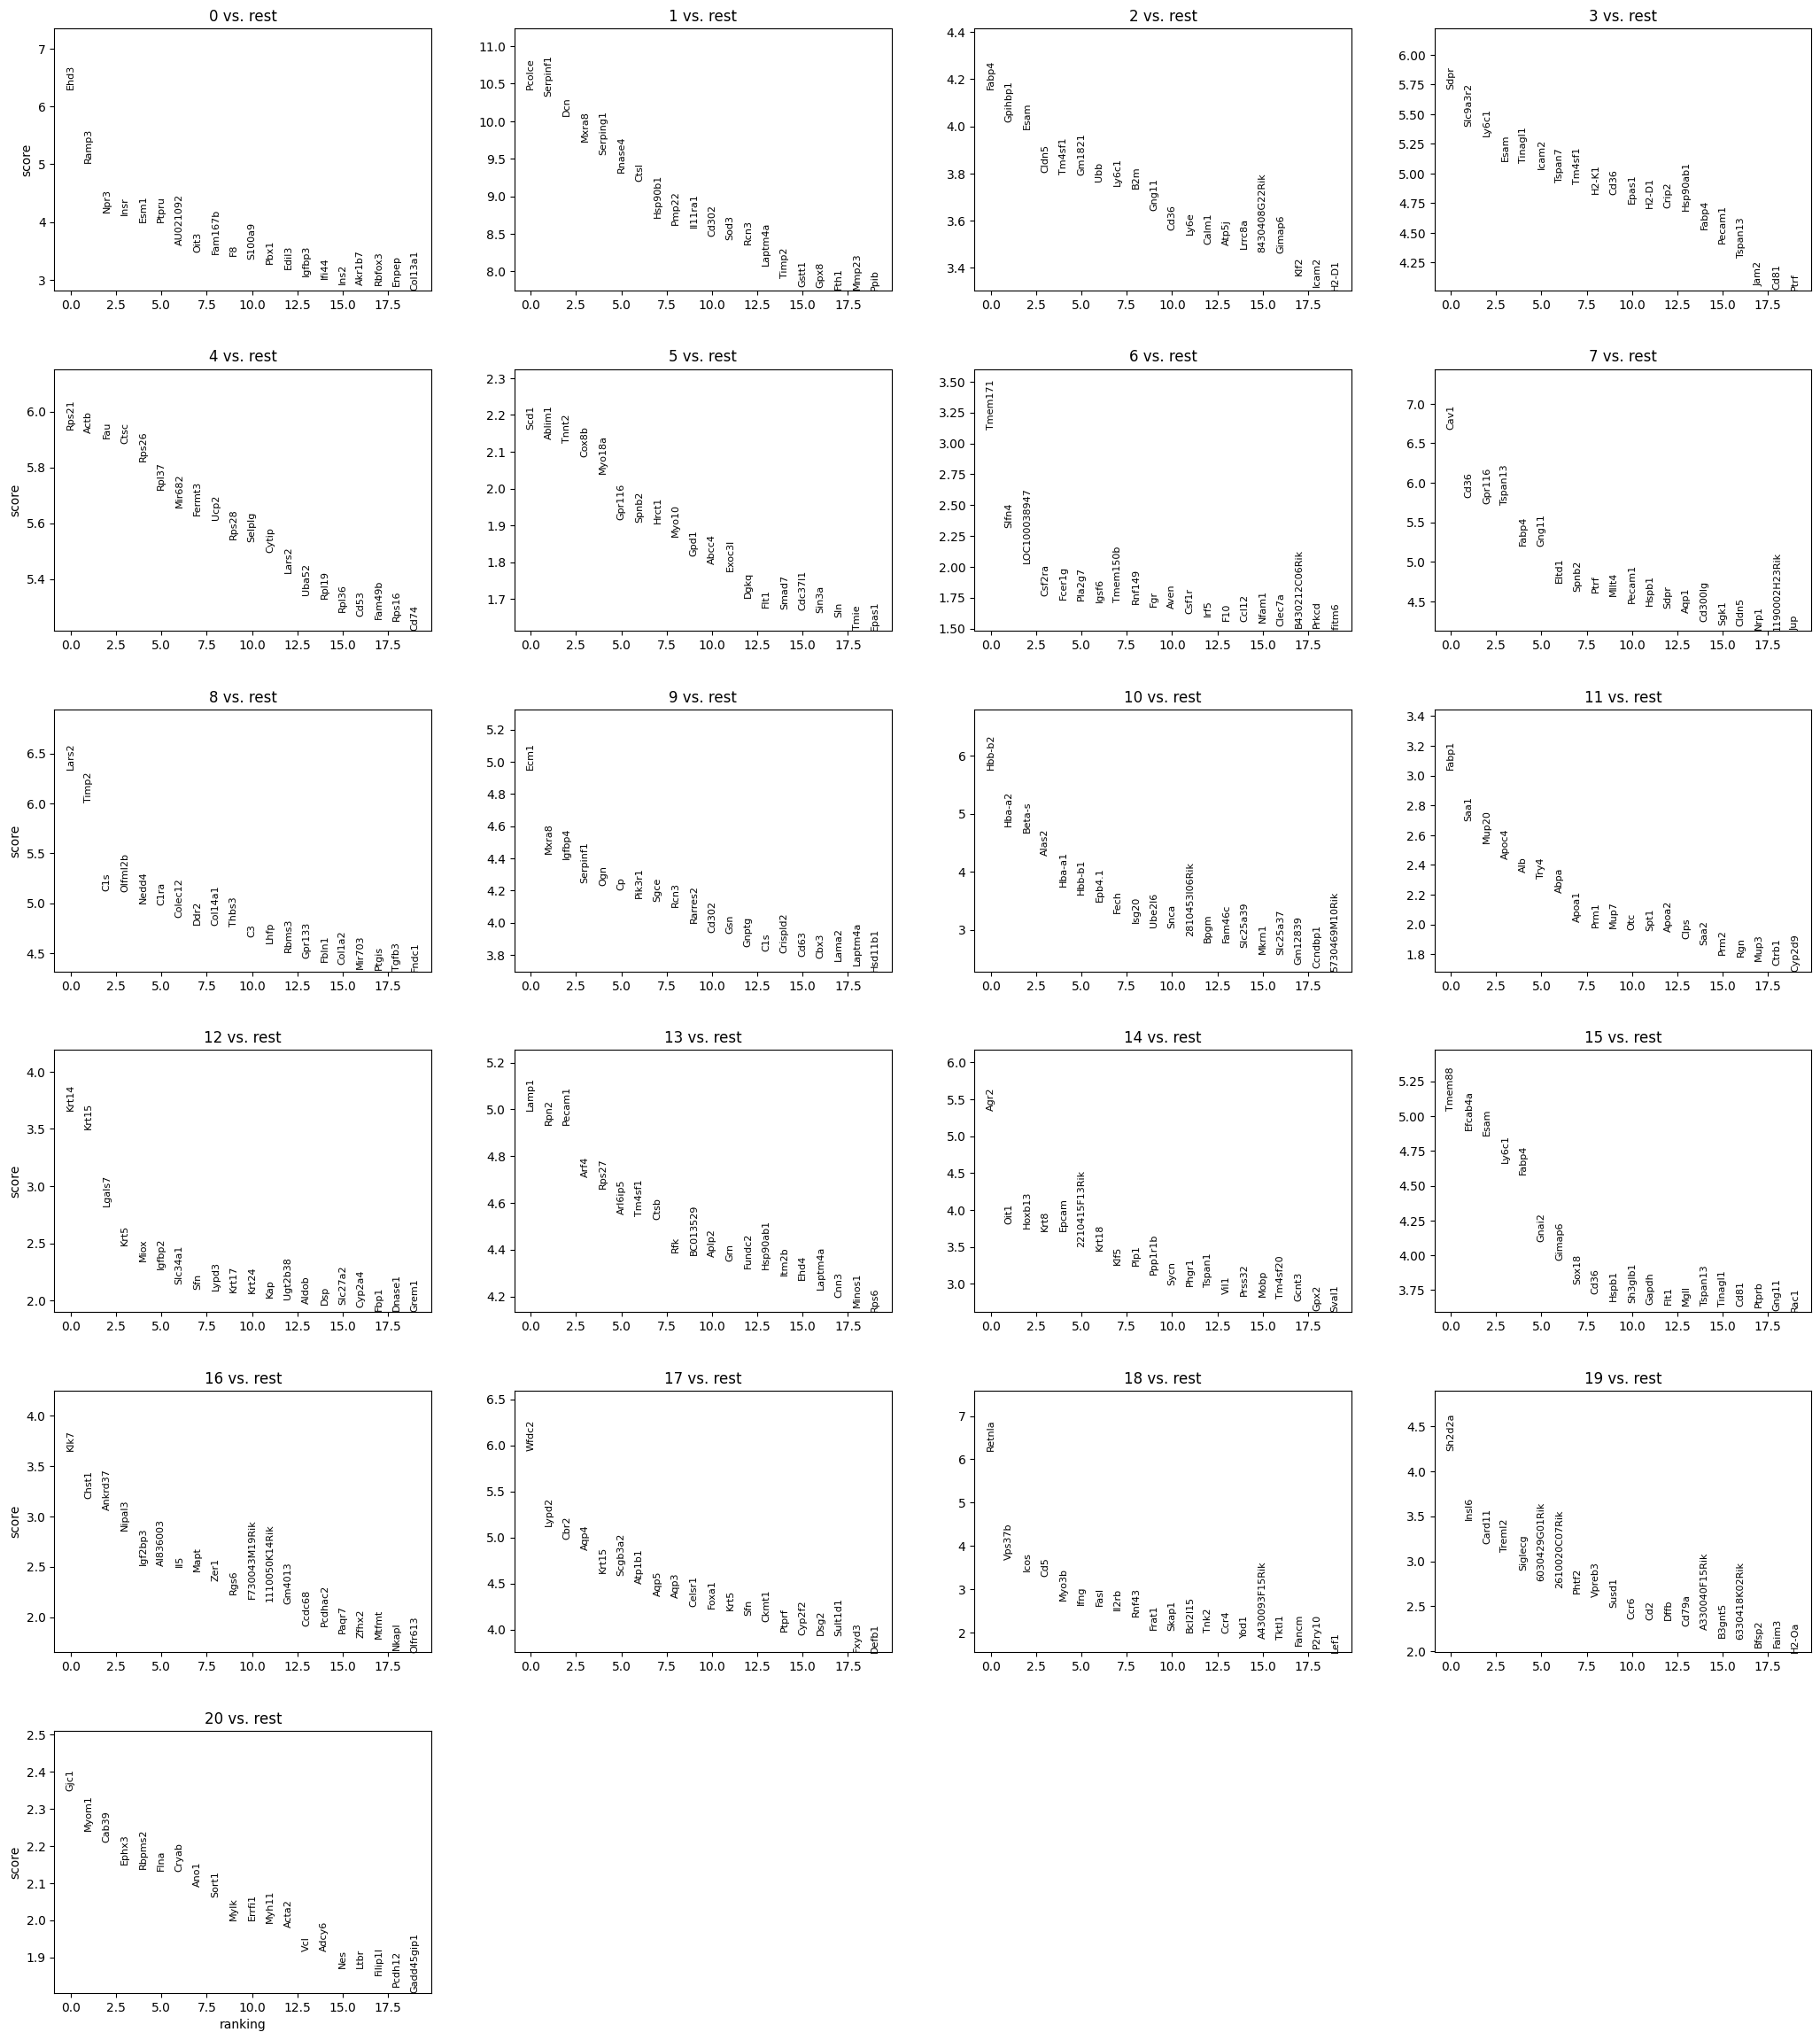

In [39]:
# Identify marker genes for each cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

# Plot marker genes
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

### Annotating Clusters with Cell Types

1. **Check Metadata Columns**:
   - Use the following code to inspect the available metadata in the dataset, such as `leiden` clusters and known cell type annotations:
     ```python
     print(adata.obs.columns)
     ```

2. **Visualize Clusters with Known Annotations**:
   - Create a UMAP plot to compare the clustering results (`leiden`) with known cell type annotations (`cell_ontology_class`):
     ```python
     sc.pl.umap(adata, color=['cell_ontology_class', 'leiden'])
     ```

3. **Map Clusters to Cell Types**:
   - Based on marker genes and prior knowledge, assign biological identities to each cluster. Below is an expanded mapping for common cell types in the aorta:
     ```python
     cluster_cell_map = {
         '0': 'Endothelial cells',
         '1': 'Smooth muscle cells',
         '2': 'Fibroblasts',
         '3': 'Macrophages',
         '4': 'Antigen-presenting cells',
         '5': 'Epithelial cells',
         '6': 'Fibrocytes',
         '7': 'Pericytes',
         '8': 'T cells',
         '9': 'B cells',
         '10': 'Unknown/Other'
     }
     ```

4. **Add Cell Type Annotations**:
   - Map the cluster labels (`leiden`) to their respective cell types and add the annotations to the dataset:
     ```python
     adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_cell_map)
     ```

5. **Visualize Updated Annotations**:
   - Generate a UMAP plot with the newly assigned cell type annotations:
     ```python
     sc.pl.umap(adata, color='cell_type')
     ```

### Key Insights:
- **Cell Type Mapping**:
  - Each cluster is annotated with a biological identity based on its marker genes and known roles in aortic tissue.
  - Common cell types include endothelial cells, smooth muscle cells, fibroblasts, macrophages, and immune cells.

- **Unknown Clusters**:
  - Clusters that remain unannotated are labeled as "Unknown/Other" and can be further investigated using marker gene analysis.

- **Biological Relevance**:
  - This step provides biological context for the clustering results and facilitates downstream analyses, such as identifying cell type-specific marker genes or studying functional pathways.

This process ensures that each cluster is connected to its biological role, enabling a deeper understanding of the aortic tissue composition.


Index(['FACS.selection', 'age', 'cell', 'cell_ontology_class',
       'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex',
       'subtissue', 'tissue', 'n_genes', 'n_counts', 'louvain', 'leiden',
       'leiden_5', 'leiden_10', 'leiden_15', 'leiden_20', 'leiden_30',
       'cell_type'],
      dtype='object')


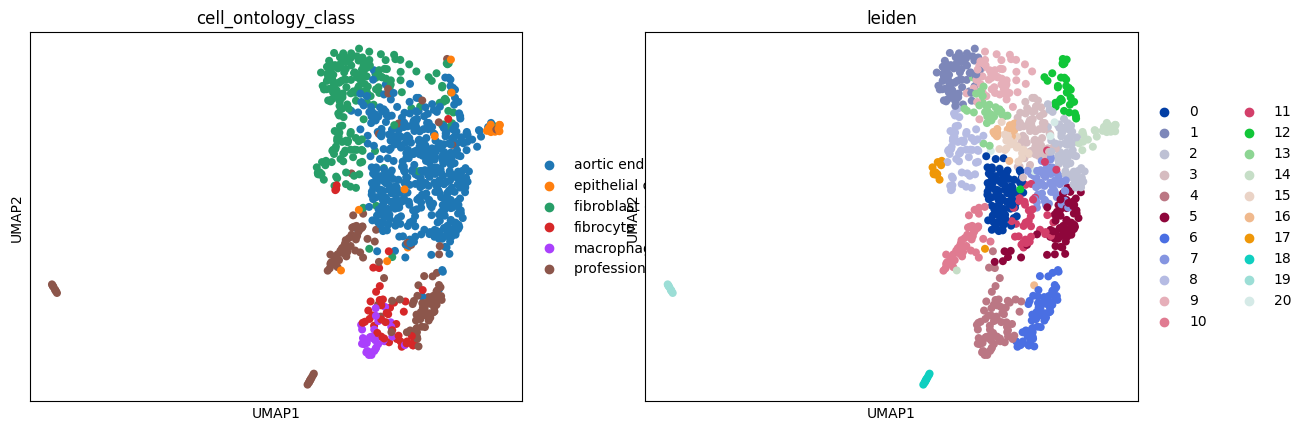

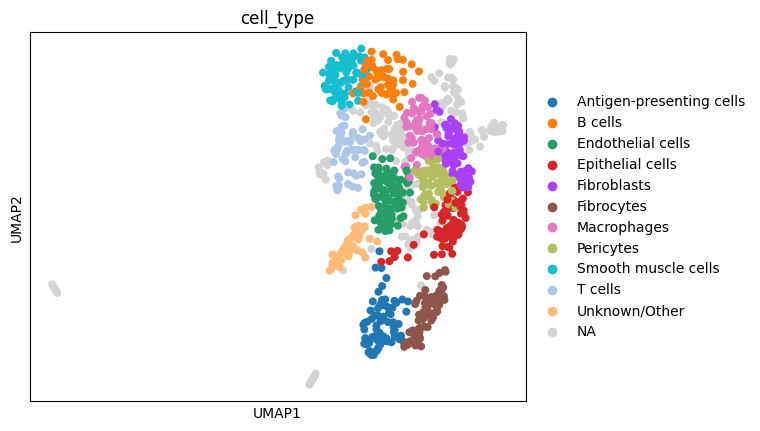

In [41]:
# Check available metadata
print(adata.obs.columns)

# Visualize clusters with known annotations
sc.pl.umap(adata, color=['cell_ontology_class', 'leiden'])

cluster_cell_map = {
    '0': 'Endothelial cells',  # Likely vascular cells
    '1': 'Smooth muscle cells',  # Supporting vascular tissue
    '2': 'Fibroblasts',  # Structural support cells
    '3': 'Macrophages',  # Immune cells
    '4': 'Antigen-presenting cells',  # Immune activators
    '5': 'Epithelial cells',  # Lining or barrier cells
    '6': 'Fibrocytes',  # Repair and maintenance cells
    '7': 'Pericytes',  # Vascular-associated cells
    '8': 'T cells',  # Immune regulatory cells
    '9': 'B cells',  # Antibody-producing immune cells
    '10': 'Unknown/Other'  # To capture unclassified clusters
}

# Map the cell types to their respective clusters
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_cell_map)

# Visualize the updated UMAP with cell type annotations
sc.pl.umap(adata, color='cell_type')

/Users/kryptonempyrean/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/Users/kryptonempyrean/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:459: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/Users/kryptonempyrean/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/Users/kryptonempyrean/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/kryptonempyrean/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: overflow encountered in expm1
  foldchanges = (sel

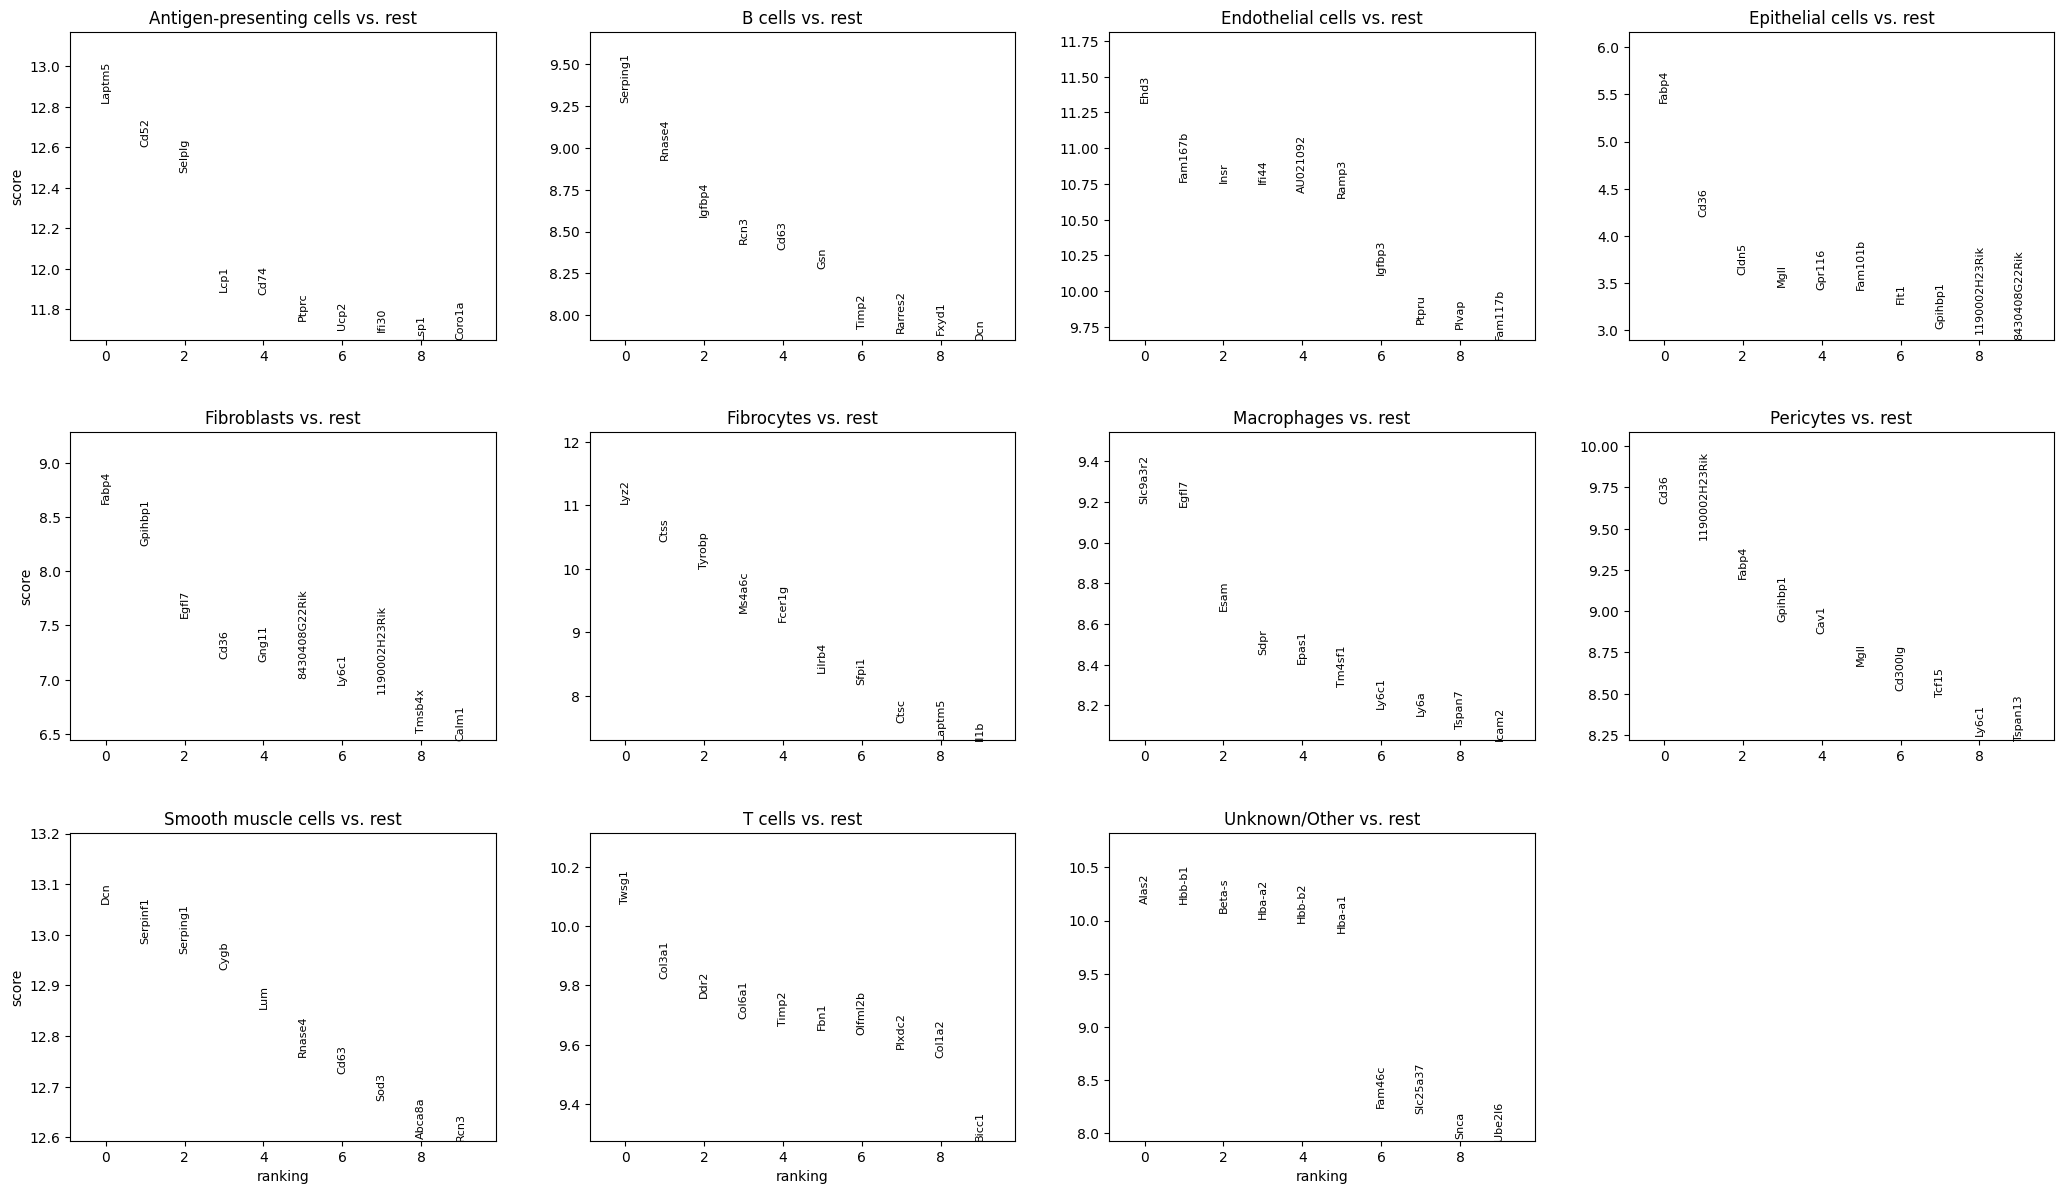

In [43]:
# Find top marker genes for a specific cluster
sc.tl.rank_genes_groups(adata, 'cell_type', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

### Partition-based Graph Abstraction (PAGA)

PAGA is a graph-based method for analyzing relationships between clusters of cells. It provides insights into the global structure of the data, such as potential developmental trajectories or transitions between cell populations.

1. **Compute PAGA**:
   - The PAGA algorithm constructs a graph where each node represents a cluster of cells, and the edges represent the strength of connectivity between clusters:
     ```python
     sc.tl.paga(adata)
     ```
   - PAGA computes the connectivity between clusters based on the neighborhood graph, revealing potential transitions or shared states between cell populations.

2. **Visualize PAGA**:
   - The `paga` plot shows the relationships between clusters in a simplified graph structure:
     ```python
     sc.pl.paga(adata, color=['cell_type'])
     ```
   - Nodes are colored by their corresponding cell type annotations, providing biological context for the graph.

3. **Combine PAGA with UMAP**:
   - Integrate PAGA with UMAP to visualize both the global structure (PAGA graph) and local structure (UMAP embedding) of the data:
     ```python
     sc.tl.draw_graph(adata)
     sc.pl.draw_graph(adata, color=['cell_type'])
     ```

### Key Insights:
- **Cluster Connectivity**:
  - PAGA highlights the connections between clusters, showing which cell types or states are closely related.
  - For example, smooth muscle cells may show strong connectivity with fibroblasts, indicating a potential transitional relationship.

- **Trajectory Analysis**:
  - If the data represents a developmental process (e.g., cell differentiation), PAGA can uncover trajectories between clusters.
  - The graph structure can help identify starting and ending points, as well as intermediate states.

- **UMAP Integration**:
  - By overlaying PAGA on the UMAP embedding, you can interpret the global transitions in the context of local cell groupings.

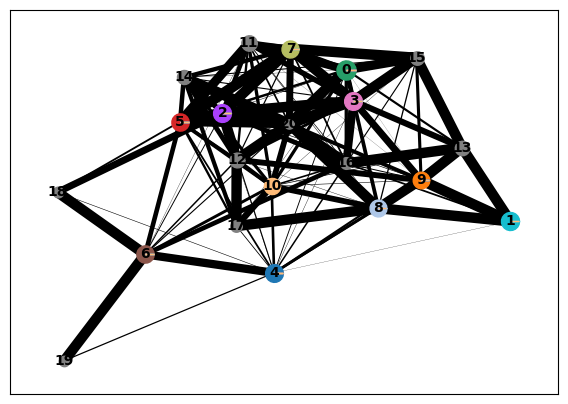

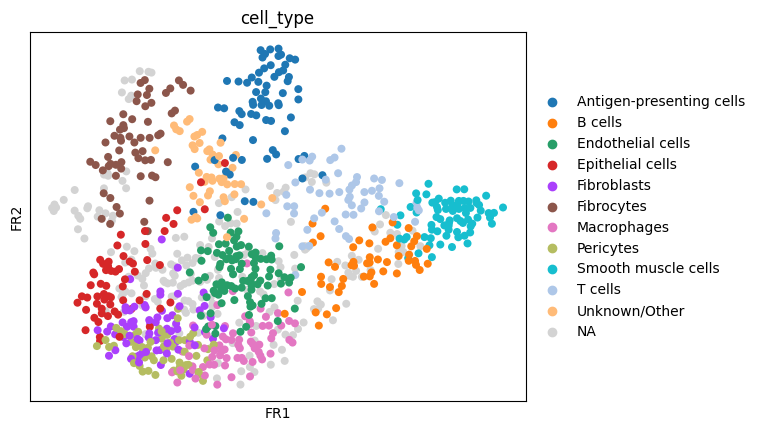

In [45]:
# Compute PAGA (Partition-based Graph Abstraction)
sc.tl.paga(adata)
sc.pl.paga(adata, color=['cell_type'])

# Combine PAGA with UMAP
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color=['cell_type'])

### PAGA Results and Cluster Connectivity

#### **Top Panel: PAGA Connectivity Graph**
1. **Graph Overview**:
   - The PAGA graph represents the connectivity between clusters, where:
     - **Nodes**: Represent individual clusters (based on Leiden clustering).
     - **Edges**: Indicate the connectivity strength between clusters based on the neighborhood graph.
     - **Edge Thickness**: The width of the edges corresponds to the strength of connectivity, with thicker edges indicating stronger relationships between clusters.

2. **Key Observations**:
   - **Strong Connectivity**:
     - Clusters `3`, `0`, and `1` show strong connectivity, suggesting they share similar gene expression profiles or represent related cell states.
   - **Isolated Nodes**:
     - Cluster `4` appears weakly connected to the main graph, indicating a distinct cell population or a rare cell type.

3. **Implications**:
   - Strongly connected clusters may represent transitional states or closely related cell types.
   - Weakly connected or isolated clusters could be rare or distinct cell populations, warranting further investigation.

---

#### **Bottom Panel: PAGA Integrated with Cell Type Annotations**
1. **Graph Layout**:
   - The PAGA graph is combined with a layout that integrates cell type annotations (`cell_type`) for each cluster.

2. **Key Observations**:
   - **Endothelial Cells (Blue)**:
     - These cells form a tightly connected region, highlighting their similarity in gene expression.
   - **Smooth Muscle Cells (Teal)**:
     - Connected to fibrocytes and fibroblasts, suggesting potential transitional relationships.
   - **Macrophages and T Cells**:
     - Show distinct clusters, consistent with their roles as immune cell types.
   - **Rare Cell Types**:
     - Clusters such as antigen-presenting cells (brown) and pericytes (purple) are well-separated, reflecting their unique roles.

3. **Insights from Transitions**:
   - Transitions between fibroblasts, fibrocytes, and smooth muscle cells suggest potential differentiation pathways or functional overlap.
   - Immune cells (e.g., macrophages, T cells, B cells) form distinct regions, as expected, reflecting their specialized roles in immunity.


### Further Analysis and Plots

We keep on analyzing a specific set of genes in the data set.

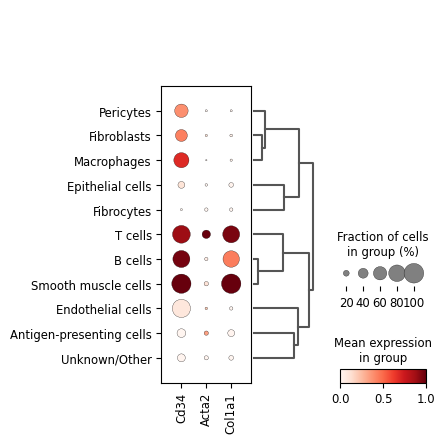

In [60]:
# Define key genes to visualize
key_genes = ['Cd34', 'Acta2', 'Col1a1']

# Dot plot for selected genes
sc.pl.dotplot(
        adata,
        key_genes,
        groupby='cell_type',  # Use 'leiden' for clusters
        dendrogram=True,
        standard_scale='var'
)

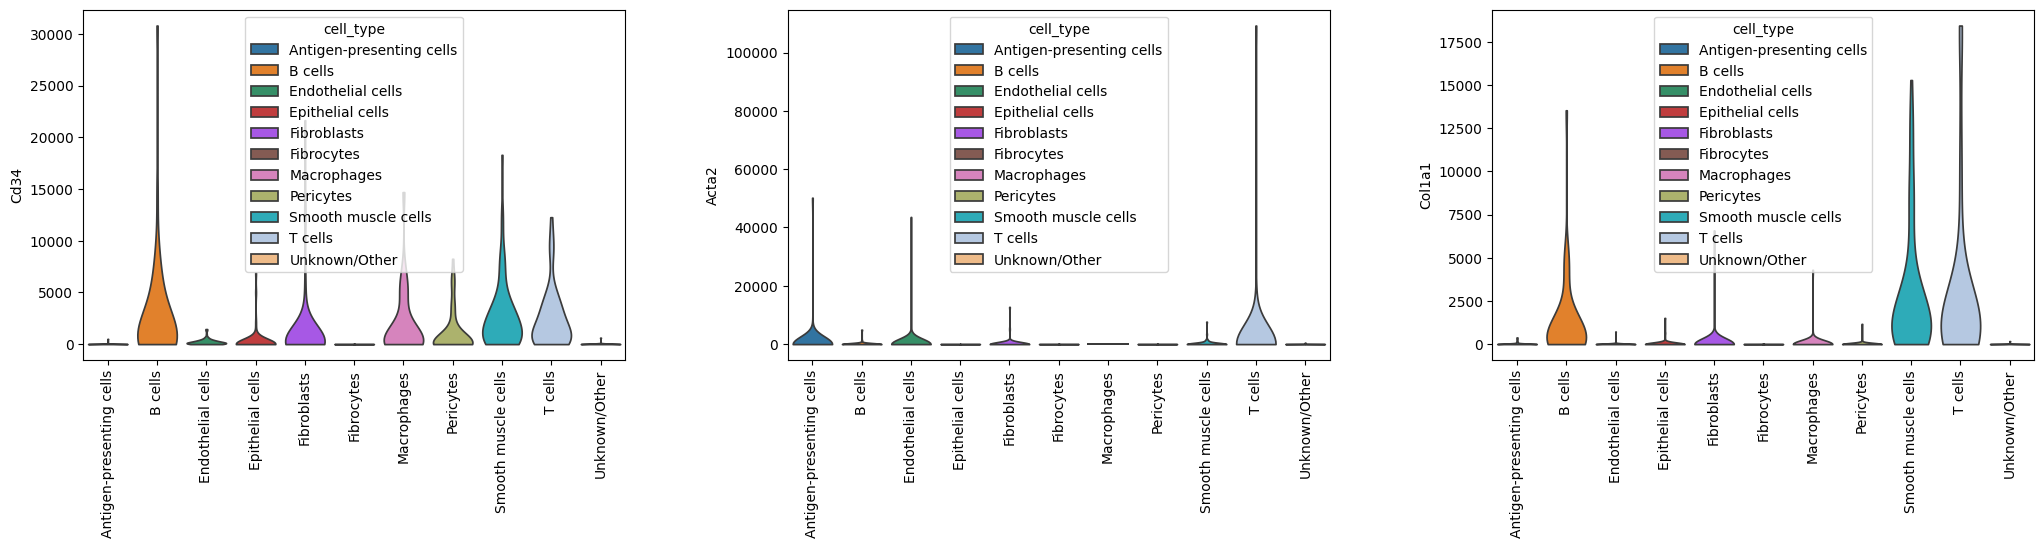

In [48]:
# Violin plot for selected marker genes
sc.pl.violin(
    adata,
    ['Cd34', 'Acta2', 'Col1a1'],  
    groupby='cell_type',
    stripplot=False,
    scale='width',
    rotation=90
)

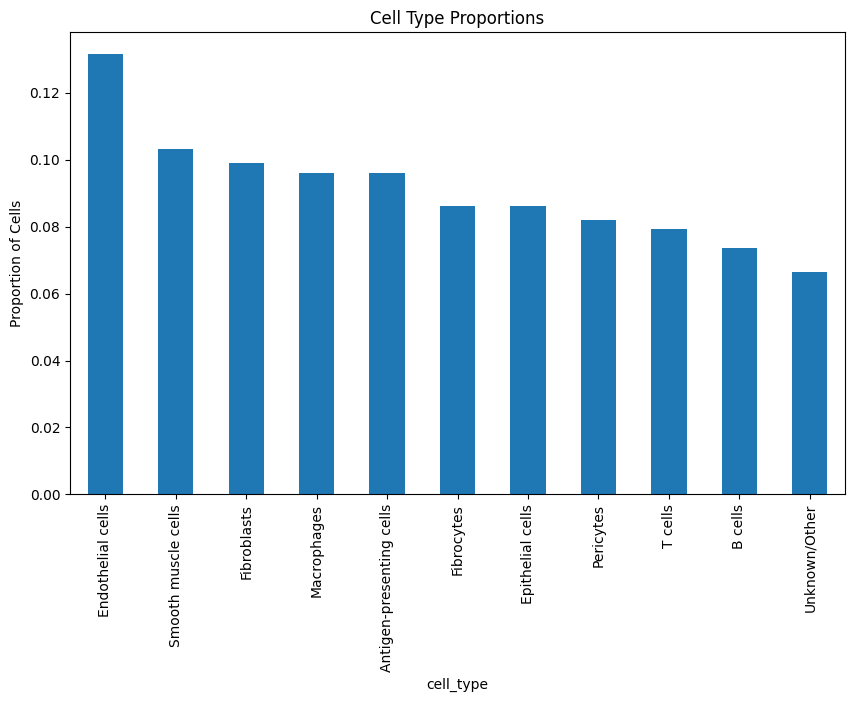

In [49]:
# Add cell type proportions
cell_counts = adata.obs['cell_type'].value_counts(normalize=True)

# Create a bar plot
import matplotlib.pyplot as plt
cell_counts.plot(kind='bar', figsize=(10, 6), title='Cell Type Proportions')
plt.ylabel('Proportion of Cells')
plt.show()

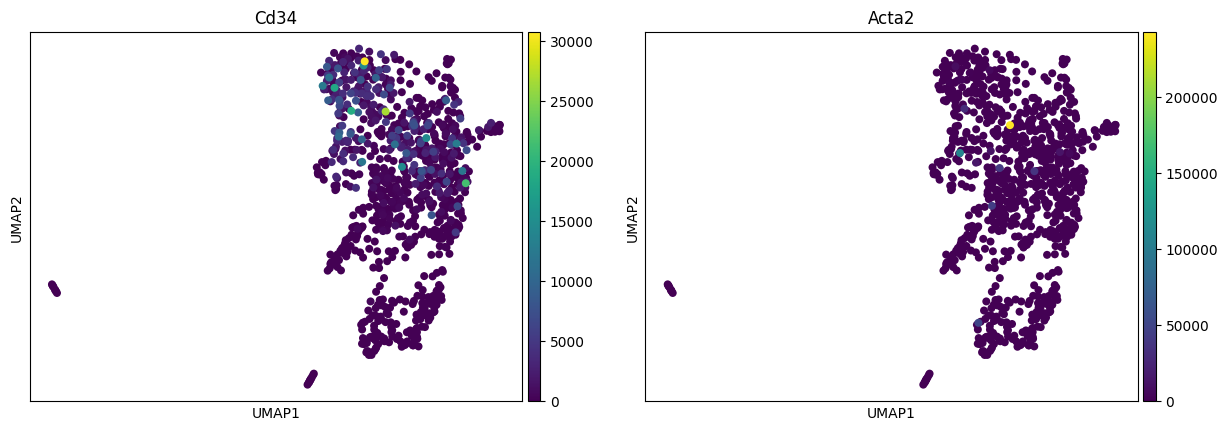

In [50]:
# Plot expression of a specific gene
sc.pl.umap(adata, color=['Cd34', 'Acta2'], cmap='viridis')

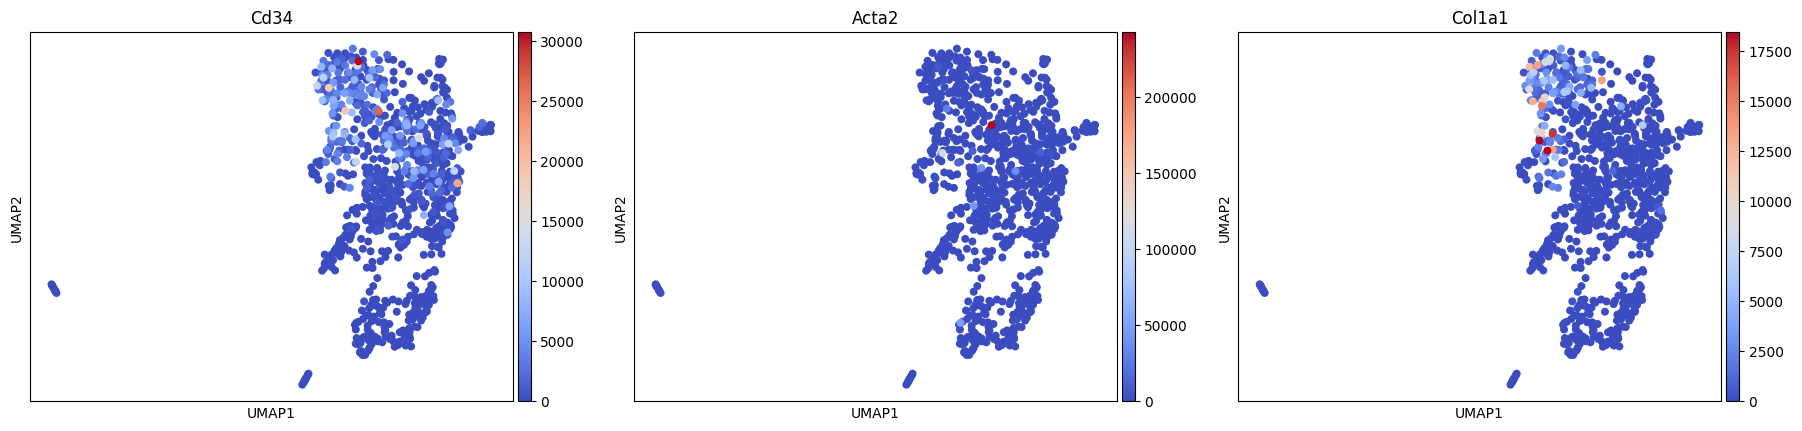

In [51]:
# Multi-gene expression on UMAP
genes_to_plot = ['Cd34', 'Acta2', 'Col1a1']
sc.pl.umap(adata, color=genes_to_plot, cmap='coolwarm', ncols=3)